In [3]:
import os
import csv
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

ヒストグラムプロットを ./results_yscale_log\original\histogram_plot.png に保存しました。


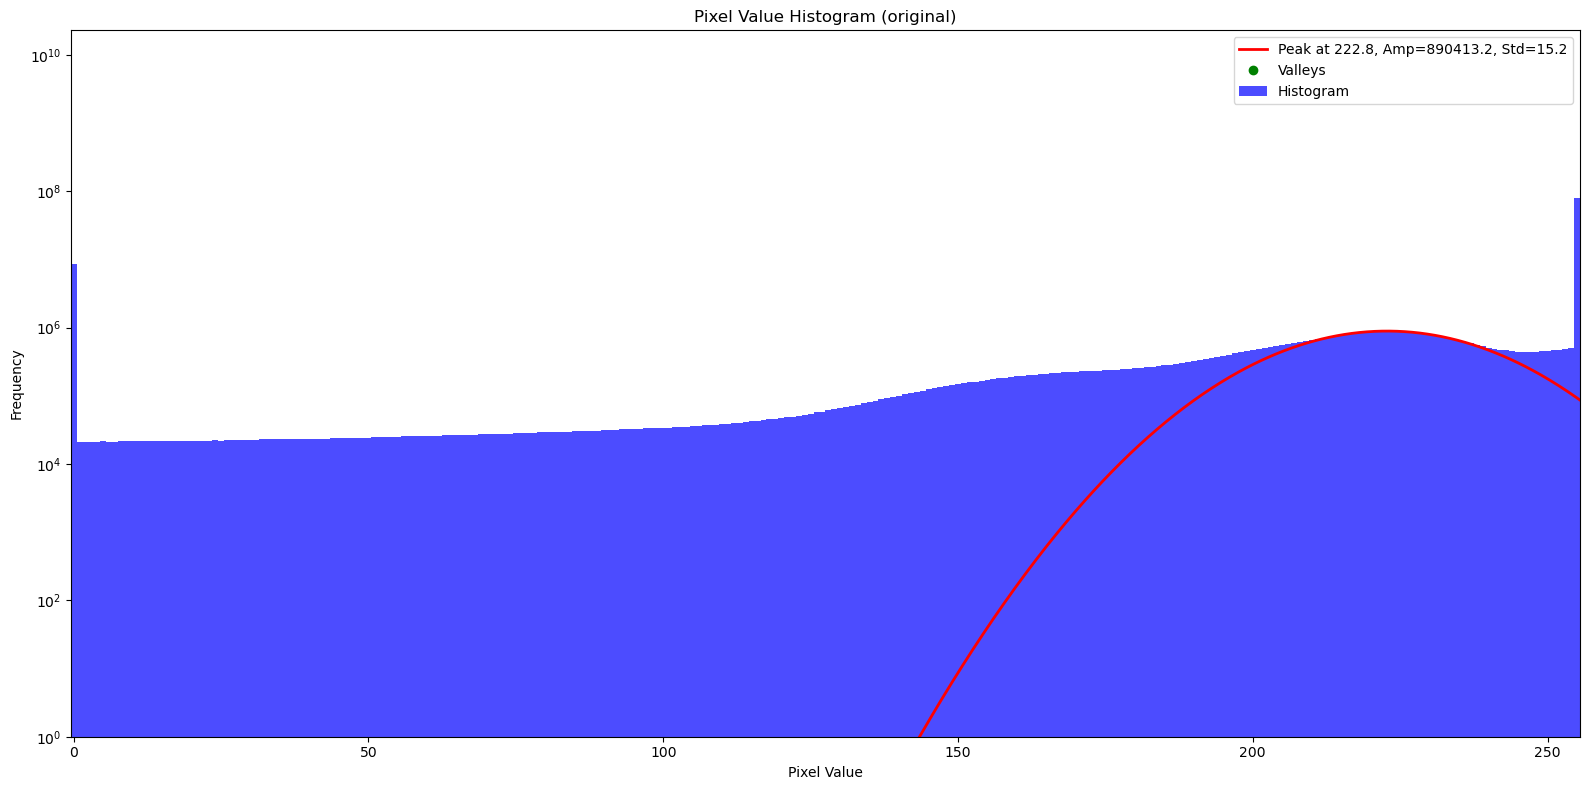

ヒストグラムを ./results_yscale_log\original\histogram_data.csv に出力しました。
ガウスフィッティング結果を ./results_yscale_log\original\gaussian_fits.csv に出力しました。
ヒストグラムプロットを ./results_yscale_log\synthesis\histogram_plot.png に保存しました。


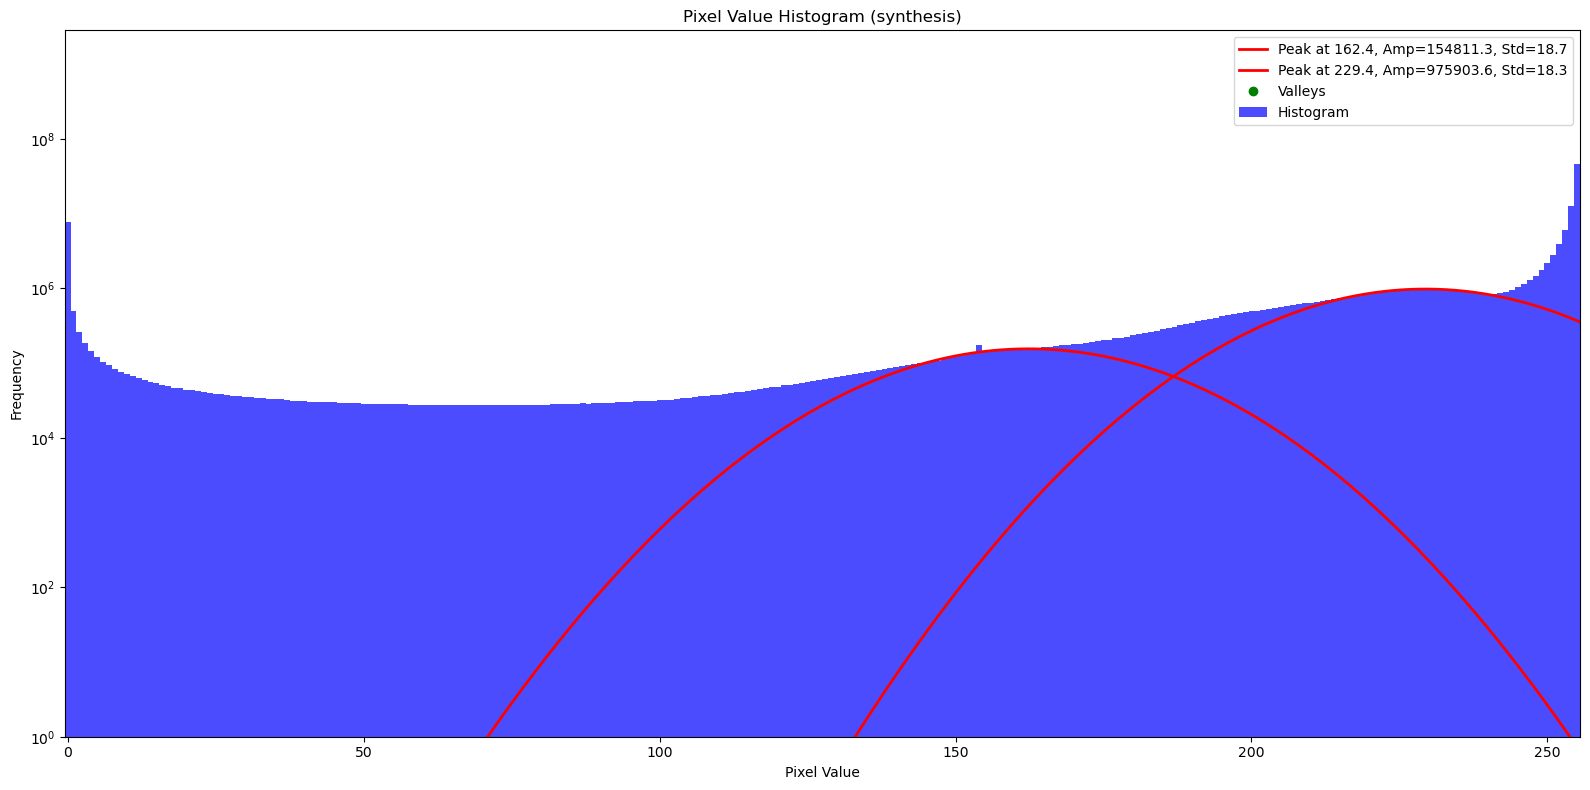

ヒストグラムを ./results_yscale_log\synthesis\histogram_data.csv に出力しました。
ガウスフィッティング結果を ./results_yscale_log\synthesis\gaussian_fits.csv に出力しました。


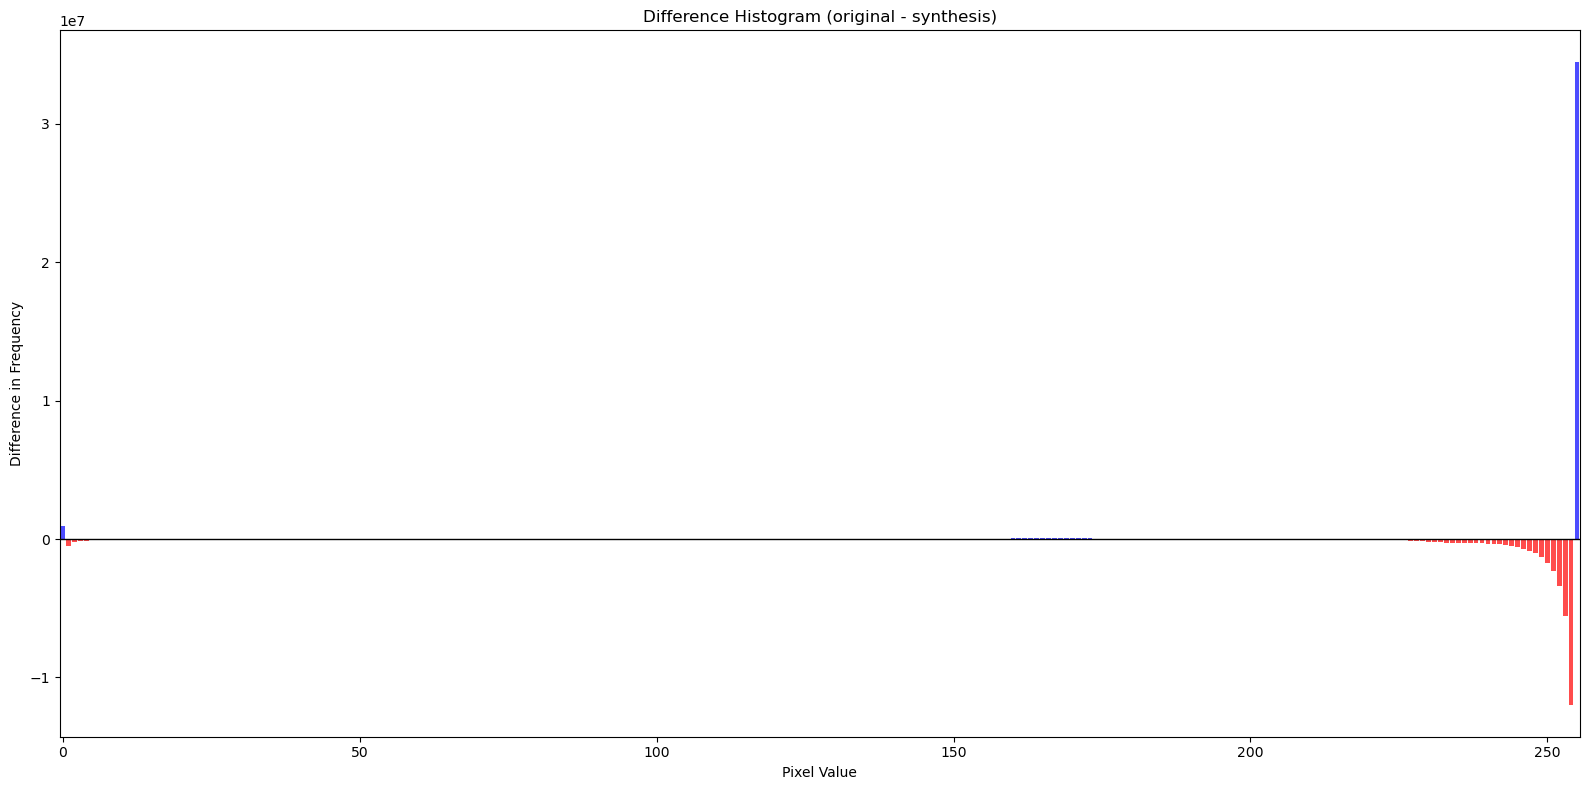

差分プロットを ./results_yscale_log/difference\difference_plot.png に保存しました。
差分データを ./results_yscale_log/difference\difference_data.csv に出力しました。
YOKI = 0.5200741607917765


In [4]:
def compute_hist_and_peaks(folder_path):
    """
    指定したフォルダ内の TIFF 画像をすべて読み込み、
    合計ヒストグラムを計算し、ガウスフィットして
    ピークの振幅などを取得する（描画はしない）。

    Returns:
        hist (np.ndarray): 0-255 の合計ヒストグラム
        fitted_peaks (list): [(mean, amplitude, stddev), ...] のリスト
        peak_max_value (float): 見つかったガウスフィット中でもっとも大きい振幅
    """
    # TIFF ファイルを全部検索
    image_files = glob(os.path.join(folder_path, "*.tif"))
    if not image_files:
        print(f"フォルダ {folder_path} に画像が見つかりません。")
        return np.zeros(256), [], 0.0

    # 0～255 の合計ヒストグラム
    total_histogram = np.zeros(256)

    for image_file in image_files:
        image = Image.open(image_file).convert('L')  # グレースケール
        image_data = np.array(image)
        hist, _ = np.histogram(image_data, bins=256, range=(0, 255))
        total_histogram += hist

    # ガウス関数
    def gaussian(x, amp, mean, stddev):
        return amp * np.exp(-(x - mean)**2 / (2*stddev**2))

    # ピークを検出＆ガウスフィットする関数
    def detect_and_fit_peak(hist, x_data, search_slice, peak_threshold=10):
        # 零周辺を考慮して log ヒストグラムでピーク検出
        log_hist = np.log(1 + hist)
        peaks, _ = find_peaks(log_hist[search_slice], prominence=0.1)
        peaks = peaks + search_slice.start  # グローバルインデックスに戻す

        if len(peaks) == 0:
            return None

        peak = peaks[0]
        # そのピークがあまりにも低い場合はスキップ
        if hist[peak] <= peak_threshold:
            return None

        # ピーク周辺 ±10 をフィット範囲に
        fit_slice = slice(max(0, peak-10), min(256, peak+11))
        x_fit = x_data[fit_slice]
        y_fit = hist[fit_slice]

        p0 = [np.max(y_fit), peak, 5]  # 初期値
        try:
            popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            # popt = [amp, mean, stddev]
            return (popt[1], popt[0], popt[2])  # (mean, amp, std)
        except RuntimeError:
            return None

    x_data = np.arange(256)

    # ガウスフィットの候補（例: 150-200, 200-254にピークがある想定）
    fitted_peaks = []
    peak_1 = detect_and_fit_peak(total_histogram, x_data, slice(150, 200), peak_threshold=5)
    peak_2 = detect_and_fit_peak(total_histogram, x_data, slice(200, 254), peak_threshold=10)
    if peak_1 is not None:
        fitted_peaks.append(peak_1)
    if peak_2 is not None:
        fitted_peaks.append(peak_2)

    # 最大振幅を取得
    peak_max_value = 0
    for (mean, amp, stddev) in fitted_peaks:
        if amp > peak_max_value:
            peak_max_value = amp

    return total_histogram, fitted_peaks, peak_max_value


def plot_folder_hist(folder_path, results_dir, yscale,
                     total_histogram, fitted_peaks, global_max_amp):
    """
    compute_hist_and_peaks で取得したヒストグラムとフィット結果を
    実際にプロットして保存する。さらに CSV 出力も行う。
    """
    os.makedirs(results_dir, exist_ok=True)

    # ガウス関数
    def gaussian(x, amp, mean, stddev):
        return amp * np.exp(-(x - mean)**2 / (2*stddev**2))

    # バレー（谷）の検出例 (平滑化して find_peaks する方法)
    inverted_histogram = np.flip(total_histogram)
    smoothed_histogram = gaussian_filter1d(inverted_histogram, sigma=2.7)

    # fitted_peaks が複数ある場合に隣接するピーク間の谷を探す
    valleys = []
    sorted_peaks = sorted(fitted_peaks, key=lambda x: x[0])
    for i in range(len(sorted_peaks) - 1):
        peak_start = int(sorted_peaks[i][0])
        peak_end = int(sorted_peaks[i+1][0])
        valley_range = slice(peak_start, peak_end)
        valley_candidates, _ = find_peaks(smoothed_histogram[valley_range],
                                          prominence=1)
        valleys.extend(valley_candidates + peak_start)

    # プロット
    fig, ax = plt.subplots(figsize=(16, 8))

    # ヒストグラムバー
    ax.bar(np.arange(256),
           total_histogram,
           width=1,
           color='blue',
           alpha=0.7,
           label="Histogram")
    ax.set_title(f"Pixel Value Histogram ({os.path.basename(folder_path)})")
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Frequency")
    ax.set_xlim(-0.5, 255.5)

    # ガウスフィットの描画
    x_fine = np.linspace(-0.5, 255.5, 1000)
    for (mean, amp, stddev) in fitted_peaks:
        y_gauss = gaussian(x_fine, amp, mean, stddev)
        ax.plot(x_fine, y_gauss, color='red', lw=2,
                label=f"Peak at {mean:.1f}, Amp={amp:.1f}, Std={stddev:.1f}")

    # 谷を緑色マーカーで
    ax.plot(valleys, total_histogram[valleys], 'go', label="Valleys")

    # スケール設定
    ax.set_yscale(yscale)
    if yscale == "log":
        # 0 のデータがある場合は log(0) がとれないので下限は 1 に設定
        ax.set_ylim(1,)
    else:
        # 線形の場合は共通ピーク振幅の 1.1倍ほどまで表示
        ax.set_ylim(0, global_max_amp * 1.1 if global_max_amp > 0 else 1)

    ax.legend()
    plt.tight_layout()

    # グラフ保存
    plot_path = os.path.join(results_dir, "histogram_plot.png")
    plt.savefig(plot_path, dpi=300)
    print(f"ヒストグラムプロットを {plot_path} に保存しました。")

    plt.show()

    # ヒストグラム CSV 出力
    hist_csv = os.path.join(results_dir, "histogram_data.csv")
    with open(hist_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Pixel Value", "Frequency"])
        for i, freq in enumerate(total_histogram):
            writer.writerow([i, freq])
    print(f"ヒストグラムを {hist_csv} に出力しました。")

    # ガウスフィット CSV 出力
    fit_csv = os.path.join(results_dir, "gaussian_fits.csv")
    with open(fit_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Peak Index", "Mean", "Amplitude", "Stddev"])
        for idx, (mean, amp, std) in enumerate(fitted_peaks):
            writer.writerow([idx + 1, mean, amp, std])
    print(f"ガウスフィッティング結果を {fit_csv} に出力しました。")


if __name__ == "__main__":
    # 解析するフォルダ (必要に応じてパスを修正してください)
    folders = ["./original", "./synthesis"]
    
    # 目盛りスケールの指定
    y_scale = input("Please select 'log' or 'linear': ").strip()

    # フォルダごとにヒストグラムを計算し、ピーク振幅を取得
    # ここではまだ描画しない
    all_histograms = {}
    all_fitted_peaks = {}
    max_amplitude_list = []

    for folder in folders:
        hist, fitted_peaks, peak_max = compute_hist_and_peaks(folder)
        all_histograms[folder] = hist
        all_fitted_peaks[folder] = fitted_peaks
        max_amplitude_list.append(peak_max)

    # 共通最大ピーク（複数フォルダ間での最大値）
    global_max_amp = max(max_amplitude_list) if max_amplitude_list else 0

    # ここで、全フォルダを“共通のスケール”で描画・出力する
    for folder in folders:
        results_dir = os.path.join(f"./results_yscale_{y_scale}", os.path.basename(folder))
        plot_folder_hist(folder,
                         results_dir,
                         yscale=y_scale,
                         total_histogram=all_histograms[folder],
                         fitted_peaks=all_fitted_peaks[folder],
                         global_max_amp=global_max_amp)

    # ===========================
    # 差分プロット: original - synthesis
    # ===========================
    if ("./original" in all_histograms) and ("./synthesis" in all_histograms):
        original_hist = all_histograms["./original"]
        synthesis_hist = all_histograms["./synthesis"]
        difference = original_hist - synthesis_hist
        
        # YOKI の計算
        abs_diff_sum = np.sum(np.abs(difference))
        total_pixels = np.sum(original_hist)
        value = abs_diff_sum / total_pixels  # YOKI

        # 色分け (プラス=青, マイナス=赤, ゼロ=灰)
        colors = ["blue" if diff > 0 else "red" if diff < 0 else "gray"
                  for diff in difference]

        plt.figure(figsize=(16, 8))
        plt.bar(np.arange(256),
                difference,
                color=colors,
                alpha=0.7)

        # ここで X 軸の範囲を -0.5 から 255.5 に設定
        plt.xlim(-0.5, 255.5)

        plt.axhline(y=0, color='black', linewidth=1)
        plt.title("Difference Histogram (original - synthesis)")
        plt.xlabel("Pixel Value")
        plt.ylabel("Difference in Frequency")

        plt.tight_layout()
        diff_dir = f"./results_yscale_{y_scale}/difference"
        os.makedirs(diff_dir, exist_ok=True)

        diff_plot = os.path.join(diff_dir, "difference_plot.png")
        plt.savefig(diff_plot, dpi=300)
        plt.show()
        print(f"差分プロットを {diff_plot} に保存しました。")

        # 差分データ CSV + YOKI の保存
        diff_csv = os.path.join(diff_dir, "difference_data.csv")
        with open(diff_csv, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Pixel Value", "Difference(orig - synth)"])
            for i, val in enumerate(difference):
                writer.writerow([i, val])
            writer.writerow([])
            writer.writerow(["YOKI", value])

        print(f"差分データを {diff_csv} に出力しました。")
        print("YOKI =", value)
    else:
        print("original と synthesis の両方のヒストグラムが見つからなかったため、差分は作成しません。")